In [2]:
import import_ipynb
from Functions import *

importing Jupyter notebook from Functions.ipynb


# Main Model

In [31]:
class ImageStackDNN(nn.Module):
    def __init__(self, input_channels):
        super(ImageStackDNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 50 * 50, 1024)
        self.fc2 = nn.Linear(1024, 256 * 50 * 50)

        # Final conv to reduce to 1 channel
        self.final_conv = nn.Conv2d(256, 1, kernel_size=1)

    def forward(self, x):
        # x shape: (1, N*3, 400, 400)
        x = Fun.relu(self.conv1(x))      # -> (1, 64, 400, 400)
        x = self.pool(x)               # -> (1, 64, 200, 200)
        x = Fun.relu(self.conv2(x))      # -> (1, 128, 200, 200)
        x = self.pool(x)               # -> (1, 128, 100, 100)
        x = Fun.relu(self.conv3(x))      # -> (1, 256, 100, 100)
        x = self.pool(x)               # -> (1, 256, 50, 50)

        # Flatten for fully connected layers
        x_flat = x.view(x.size(0), -1)           # -> (1, 256*50*50)
        x_fc = Fun.relu(self.fc1(x_flat))          # -> (1, 1024)
        x_fc = Fun.relu(self.fc2(x_fc))            # -> (1, 256*50*50)

        # Reshape back to conv feature map
        x_reshaped = x_fc.view(x.size(0), 256, 50, 50)

        # Upsample back to original size
        x_up = Fun.interpolate(x_reshaped, size=(400, 400), mode='bilinear', align_corners=False)

        # Final conv to get single channel output
        output = self.final_conv(x_up)           # -> (1, 1, 400, 400)
        return Fun.sigmoid(output)


In [34]:
N=1
model = ImageStackDNN(input_channels=3 * N)  # If you have N RGB images
input_tensor = torch.randn(1, 3*N, 400, 400)  # Your image stack
output = model(input_tensor)
print(output.shape)  # Expected: torch.Size([1, 1, 400, 400])

torch.Size([1, 1, 400, 400])


In [18]:
def load_models(N,path=None):
    # Initialize Model Shapes
    modelsFrames = [FramesModel() for _ in range(N)]
    #modelsDiff = [DiffModel() for _ in range(N)]
    #modelsOF = [OFModel() for _ in range(N)]
    #modelsEdges = [EdgesModel() for _ in range(N)]
    #modelsSSIM = [SSIMModel() for _ in range(N)]
    #modelsWarp = [WarpModel() for _ in range(N)]
    #modelsClusterG = [ClusterGModel() for _ in range(N)]
    #modelsClusterRGB = [ClusterRGBModel() for _ in range(N)]
    #modelsWarpCluster = [WarpClusterModel() for _ in range(N)]
    
    # Load the state_dicts
    if path is not None:
        checkpoint = torch.load(state_path)
        for model, state_dict in zip(modelsFrames, checkpoint["frames"]):
            model.load_state_dict(state_dict)
        for model, state_dict in zip(modelsDiff, checkpoint["diff"]):
            model.load_state_dict(state_dict)
        for model, state_dict in zip(modelsOF, checkpoint["optical_flow"]):
            model.load_state_dict(state_dict)
        for model, state_dict in zip(modelsEdges, checkpoint["edges"]):
            model.load_state_dict(state_dict)
        for model, state_dict in zip(modelsSSIM, checkpoint["ssim"]):
            model.load_state_dict(state_dict)
        for model, state_dict in zip(modelsWarp, checkpoint["warp"]):
            model.load_state_dict(state_dict)
        for model, state_dict in zip(modelsClusterG, checkpoint["clusterG"]):
            model.load_state_dict(state_dict)
        for model, state_dict in zip(modelsClusterRGB, checkpoint["clusterRGB"]):
            model.load_state_dict(state_dict)
        for model, state_dict in zip(modelsWarpCluster, checkpoint["warpcluster"]):
            model.load_state_dict(state_dict)
    return modelsFrames#,modelsDiff,modelsOF,modelsEdges,modelsSSIM,modelsWarp,modelsClusterG,modelsWarpCluster

In [19]:
def AddInconsistencies(Frames,steps,Size,N):
    IncFrames = Frames.copy()
            
    IncGrid = torch.zeros(Size[0]//25, Size[1]//25)
    BinImg = np.zeros(Size)
    Bin = torch.tensor(np.zeros(Frames[0].shape[1:]).astype(np.float32))
            
    steps = random.randint(1, Steps)
    for s in range(steps):
        x = random.randint(0, 5 * Size[0] // 6)
        y = random.randint(0, 5 * Size[1] // 6)
        xl = random.randint(10, Size[0] // 10)
        yl = random.randint(10, Size[1] // 10)
                
        for p in range(N):
            if random.random() >= 0.5 and p != N // 2:
                IncFrames[p], _ = AddOneInc2(torch.tensor(np.zeros(Frames[0].shape[:2]).astype(np.float32)), IncFrames[p], x=x, y=y, xl=xl, yl=yl)
        IncFrames[N // 2], Bin = AddOneInc2(Bin, IncFrames[N // 2], x=x, y=y, xl=xl, yl=yl)
                
    PredGrid = torch.zeros(1, 1, Size[0], Size[1])
    Bin = Bin.unsqueeze(0).unsqueeze(0)
    return PredGrid,Bin,IncFrames

# Training Function

In [20]:
def train(Path, state_path=None, N=7, Batch=10, Epochs=10, Steps=5, LR=1e-3,Stride=10):
    Size = (400, 400)  # Size of Frames
    
    #Load Models
    #modelsFrames,modelsDiff,modelsOF,modelsEdges,modelsSSIM,modelsWarp,modelsClusterG,modelsWarpCluster
    modelsFrames=load_models(N,state_path)
    
    #Initialize Optimizer
    all_parameters = []
    for model_list in [modelsFrames,modelsDiff,modelsOF,modelsEdges,modelsSSIM,modelsWarp,modelsClusterG,modelsClusterRGB,modelsWarpCluster]:
        for model in model_list:
            all_parameters += list(model.parameters())
    optimizer = optim.Adam(all_parameters, lr=LR)
    
    # Loss function
    criterion = nn.MSELoss()
    criterion1 = nn.BCELoss()
    
    Loss = []
    start_time = time.time()  # Track the start time of training
    
    total_batches = Epochs * Batch
    
    for epoch in range(Epochs):
        total_loss = 0.0
        epoch_start_time = time.time()
        
        for batch in range(Batch):
            batch_start_time = time.time()
            
            # Get Frames
            Frames = get_video_frames(Path, N, Size)
            
            PredGrid,Bin,IncFrames = AddInconsistencies(Frames,steps,Size,N)
            
            for v in range(Size[0]//Stride):
                for h in range(Size[1]//Stride):
                    if Stride*v+50<=300 and Stride*h+50<=300:
                        feat = features[:, :, v * Stride:v * Stride + 50, h * Stride:h * Stride + 50].clone().detach()
                        optimizer.zero_grad()
                        Pred = model(feat)
                        PredGrid[:, :, v * Stride:v * Stride + 50, h * Stride:h * Stride + 50] = Pred
                        b = Bin[:, :, v * Stride:v * Stride + 50, h * Stride:h * Stride + 50].clone().detach()
                        if Bin.max()>1:
                            print(Bin.max(),v,h)
                            
                        loss = criterion(Pred, b)+ \
                               criterion(Bin,torch.tensor(BinImg,dtype=torch.float32).unsqueeze(0).unsqueeze(0))+ \
                               criterion1(Pred,b)+ \
                               criterion1(Bin,torch.tensor(BinImg,dtype=torch.float32).unsqueeze(0).unsqueeze(0))
                        loss.backward()
                        optimizer.step()

                        bi = Frame2Numpy(Pred.squeeze(0).squeeze(0))
                        BinImg[v * Stride:v * Stride + 50, h * Stride:h * Stride + 50] = bi

                        elapsed_time = time.time() - start_time
                        processed_batches = epoch * Batch + batch + 1
                        remaining_batches = total_batches - processed_batches

                        if processed_batches > 0:
                            avg_time_per_batch = elapsed_time / processed_batches
                            estimated_remaining_time = avg_time_per_batch * remaining_batches
                        else:
                            estimated_remaining_time = 0

                        est_hours = int(estimated_remaining_time // 3600)
                        est_mins = int((estimated_remaining_time % 3600) // 60)
                        est_secs = int(estimated_remaining_time % 60)

                        print(f'Batch [{batch+1}/{Batch}], Loss: {loss.item():.4f}, '
                              f'ETA: {est_hours:02d}:{est_mins:02d}:{est_secs:02d}', end='\r')

                        f = Frame2Numpy(features[0, N * 3 // 2:N * 3 // 2 + 3])
                        cv2.imshow("Predicted Inconsistencies", BinImg)
                        cv2.imshow("Thresholded Prediction",(BinImg>0.5).astype(np.float32))
                        cv2.imshow("Ground Truth", Frame2Numpy(Bin.squeeze(0).squeeze(0)))
                        cv2.imshow("Inconsistencies Frame", f)
                        cv2.waitKey(10)  # Check for key press every frame

                        key = cv2.waitKey(1) & 0xFF
                        if key == 27:
                            print("Training stopped by user.")
                            cv2.destroyAllWindows()
                            return Loss, model.state_dict()

                        total_loss += loss.item()
                    
        epoch_time = time.time() - epoch_start_time
        print(f'\nEpoch [{epoch + 1}/{Epochs}], Loss: {total_loss / (Batch * 11 * 11):.6f}')
        
        LR *= 0.9
        Loss.append(total_loss)
    
    states = model.state_dict()
    cv2.destroyAllWindows()
    return Loss, states


# Training

In [21]:
cv2.destroyAllWindows()

In [22]:
State = None#torch.load("StatesBID3N300x300V10.pth")

In [23]:
L,State = train('VDB/Toons',Batch=50,state_path=State,N=3,Epochs=20,Steps=25,LR=1e-4,Stride=50)

NameError: name 'FramesModel' is not defined

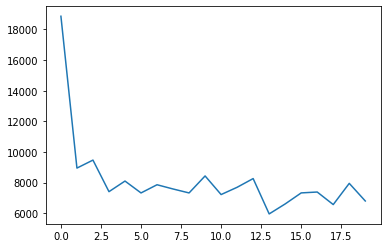

In [126]:
plt.plot(L) ##Cambios de Escenas

In [5]:
torch.save(State,"StatesBID3N300x300V11.pth")

NameError: name 'State' is not defined

# Load and Predict

In [6]:
States = torch.load("StatesBID3N300x300V11.pth")

In [7]:
Size = (300,300)
Model = DNNModel()
Model.load_state_dict(States)
Model.eval();

In [8]:
Frames = get_video_frames("AI Gen",3,Size)
Frames_Np = [cv2.cvtColor(Frames[n].permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB) for n in range(len(Frames))]

In [9]:
ThroughFrames(Frames_Np)

In [11]:
features = extract_features(Frames).unsqueeze(0)

TypeError: not enough arguments: expected 3, got 2

In [139]:
PredImg = np.zeros((300,300))
for v in range(0, 6):
    for h in range(0, 6):
        feat = features[:, :, v * 50:(v + 1) * 50, h * 50:(h + 1) * 50].clone().detach()
        Pred = Model(feat)
        PredImg[v * 50:(v + 1) * 50, h * 50:(h + 1) * 50] = Frame2Numpy(Pred.squeeze(0).squeeze(0))

In [140]:
TPred = (PredImg>0.5).astype(np.float32)
NF = [cv2.cvtColor(Frame2Numpy(f),cv2.COLOR_BGR2RGB) for f in Frames]
IFrame = NF[1].copy()
IFrame[TPred == 1] = np.array([0, 255, 0], dtype=np.uint8)

In [141]:
display_images([PredImg,TPred]+NF+[IFrame])

In [ ]:
### Add OF and more frames
### 

In [12]:
B, C, H, W = 2, 3, 128, 128  # Batch size, channels, height, width
image = torch.randn(B, C, H, W, requires_grad=True)  # Input image
flow = torch.randn(B, 2, H, W, requires_grad=True)  # Optical flow

# Target image (for loss calculation)
target_image = torch.randn(B, C, H, W)  

# Compute the warped image
warped_image = warp_image_tensor(image, flow)

# Define a loss function (e.g., MSE loss with the target image)
loss = Fun.mse_loss(warped_image, target_image)

# Backpropagate
loss.backward()

In [38]:
Imgs = get_video_frames("VDB/Toons",2,(400,400))
ThroughFrames([Frame2Numpy(f) for f in Imgs])

In [39]:
img0 = Frame2Numpy(Imgs[0])
img1 = Frame2Numpy(Imgs[1])
Imgs[0].requires_grad_()
Imgs[1].requires_grad_()
flow = pyramid_optical_flow(Imgs[0],Imgs[1],1)
flow1 = pyramid_optical_flow(Imgs[0],Imgs[1],2)
flow2 = pyramid_optical_flow(Imgs[0],Imgs[1],3)############
flow3 = pyramid_optical_flow(Imgs[0],Imgs[1],4)
Wimg = warp_image_tensor(Imgs[0].unsqueeze(0),flow.unsqueeze(0))
wimg1 = Frame2Numpy(Wimg.squeeze(0))
Wimg1 = warp_image_tensor(Imgs[0].unsqueeze(0),flow1.unsqueeze(0))
wimg2 = Frame2Numpy(Wimg1.squeeze(0))
Wimg2 = warp_image_tensor(Imgs[0].unsqueeze(0),flow2.unsqueeze(0))
wimg3 = Frame2Numpy(Wimg2.squeeze(0))
Wimg3 = warp_image_tensor(Imgs[0].unsqueeze(0),flow3.unsqueeze(0))
wimg4 = Frame2Numpy(Wimg3.squeeze(0))
criterion = nn.MSELoss()
loss = criterion(Wimg,Wimg1)
loss.backward()

In [40]:
ThroughFrames([img0,wimg1,wimg2,wimg3,wimg4])
((img1-wimg1)**2).sum(),((img1-wimg2)**2).sum(),((img1-wimg3)**2).sum(),((img1-wimg4)**2).sum()

(44.512917, 26.41956, 22.198652, 108.6468)

In [10]:
# Example usage:
image_tensor = get_video_frames("VDB\Toons",1,(500,500))[0].requires_grad_()  # Example RGB image
segmented_image = differentiable_segmentation(image_tensor, num_clusters=5,sigma=0.1)

# Display using OpenCV
display_images([Frame2Numpy(image_tensor),Frame2Numpy(segmented_image)])

crit = nn.MSELoss()
loss = crit(image_tensor,segmented_image)
loss.backward()

In [11]:
# Example usage:
image_tensor = get_video_frames("VDB\Toons",1,(500,500))[0].requires_grad_()

# Apply differentiable segmentation
num_clusters = 2  # Change the number of clusters as needed
segmented_rgb = differentiable_segmentationRGB(image_tensor, num_clusters)

display_images([Frame2Numpy(image_tensor),Frame2Numpy(segmented_rgb),Frame2Numpy(image_tensor)-Frame2Numpy(segmented_rgb),Frame2Numpy(segmented_rgb)-Frame2Numpy(image_tensor)])
crit = nn.MSELoss()
loss = crit(image_tensor,segmented_rgb)
loss.backward()

In [5]:
# Example usage:
image_tensor = get_video_frames("VDB\Toons",2,(500,500))
img1 = image_tensor[0].requires_grad_()
img2 = image_tensor[1]
# Apply differentiable segmentation
num_clusters = 2  # Change the number of clusters as needed
segmented_rgb1 = differentiable_segmentationRGB(img1, num_clusters)
segmented_rgb2 = differentiable_segmentationRGB(img2, num_clusters)

flow = pyramid_optical_flow(segmented_rgb1,segmented_rgb2,alpha=5.0)
flow1 = pyramid_optical_flow(segmented_rgb1,segmented_rgb2,alpha=10.0)
wimg = warp_image_tensor(segmented_rgb1.unsqueeze(0),flow.unsqueeze(0)).squeeze(0)
wimg1 = warp_image_tensor(segmented_rgb1.unsqueeze(0),flow1.unsqueeze(0)).squeeze(0)
ThroughFrames([Frame2Numpy(segmented_rgb1),Frame2Numpy(segmented_rgb2),Frame2Numpy(segmented_rgb1),Frame2Numpy(wimg),Frame2Numpy(segmented_rgb1),Frame2Numpy(wimg1)])
display_images([Frame2Numpy(segmented_rgb1),Frame2Numpy(segmented_rgb2),Frame2Numpy(wimg),Frame2Numpy(wimg1),Frame2Numpy(segmented_rgb2)-Frame2Numpy(wimg),Frame2Numpy(segmented_rgb2)-Frame2Numpy(wimg1)])
crit = nn.MSELoss()
loss = crit(segmented_rgb2,wimg)
loss.backward()
((Frame2Numpy(segmented_rgb2)-Frame2Numpy(wimg))**2).sum(),((Frame2Numpy(segmented_rgb2)-Frame2Numpy(wimg1))**2).sum()

(31566.203, 32562.615)

In [83]:
image_tensor = get_video_frames("VDB\Toons",1,(500,500))
img1 = image_tensor[0].requires_grad_()
display_frame(Frame2Numpy(img1))
downimg = recursive_downsample(img1.unsqueeze(0),2)
display_frame(Frame2Numpy(downimg.squeeze(0)))
print(downimg.shape)
upimg = recursive_upsample(downimg,2)
display_frame(Frame2Numpy(upimg.squeeze(0)))
print(upimg.shape)
display_frame(abs(Frame2Numpy(img1)-(Frame2Numpy(upimg.squeeze(0)))))
meanimg = (img1+upimg.squeeze(0))/2
display_frame(Frame2Numpy(meanimg))
print((abs(Frame2Numpy(img1)-(Frame2Numpy(upimg.squeeze(0))))).sum(),(abs(Frame2Numpy(img1)-(Frame2Numpy(meanimg.squeeze(0))))).sum())

torch.Size([1, 3, 125, 125])
torch.Size([1, 3, 500, 500])
26387.504 13193.752


In [8]:
image_tensor = get_video_frames("VDB\Toons",1,(400,400))
img1 = image_tensor[0].requires_grad_()
display_frame(Frame2Numpy(img1))
downimg,res = laplacian_downsample(img1.unsqueeze(0),2)
display_frame(Frame2Numpy(downimg.squeeze(0)))
print(downimg.shape)
upimg = laplacian_upsample(downimg,res)
display_frame(Frame2Numpy(upimg.squeeze(0)))
print(upimg.shape)
crit = nn.MSELoss()
loss = crit(img1,upimg)
loss.backward()
img1.grad

torch.Size([1, 3, 100, 100])
torch.Size([1, 3, 400, 400])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])